TODO : generaliser à images 32x32, etc.

In [129]:
%matplotlib inline

In [130]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [131]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [132]:
from scipy.stats import multivariate_normal, entropy

In [133]:
import math

In [134]:
import sys, os

In [135]:
import pickle

In [136]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [137]:
from waveimage import calc_U

In [138]:
MODEL = 'base'
#MODEL = 'base' 
if MODEL == 'base':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
elif MODEL == 'naive':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-naive.pkl", "rb"))
#mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-noisy-alt.pkl", "rb"))

## Creation de la base d'apprentissage

In [139]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [140]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [141]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [142]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [143]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [144]:
DEPTH_WAV = 3
NB_LABEL = 10

In [145]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u] + 1e-10 * np.eye(3))
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [146]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik_naive(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        '''if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:'''
        if h == 0:
            dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
        else:
            dist = multivariate_normal(mean = mu[c][h][u], cov = np.diag(Sigma[c][h][u] + 1e-10))
            #lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
            lik[c] =  dist.pdf(v)
        '''else:
            lik[c] = 0'''
        lik[c] = max(lik[c], 1e-16)    
    return lik

In [147]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [148]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

# Parcours predictif

In [149]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [150]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [151]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [152]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [153]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [154]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [155]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [156]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    

In [157]:
MODEL

'base'

h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            if MODEL == 'base':
                lik = calc_lik(v_predictive, h, u)
            elif MODEL == 'naive':
                lik = calc_lik_naive(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

In [158]:
h_max = 6
if MODEL == 'base':
    lik_predictive_base = {}
elif MODEL == 'naive':  
    lik_predictive_naive = {}
for c in range(10):
    if MODEL == 'base':
        lik_predictive_base[c] = {}
    elif MODEL == 'naive':  
        lik_predictive_naive[c] = {}
    for h in range(h_max):
        if MODEL == 'base':
            lik_predictive_base[c][h] = {}
        elif MODEL == 'naive':  
            lik_predictive_naive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            if MODEL == 'base':
                lik = calc_lik(v_predictive, h, u)
                lik_predictive_base[c][h][u] = lik
            elif MODEL == 'naive':
                lik = calc_lik_naive(v_predictive, h, u)
                lik_predictive_naive[c][h][u] = lik

In [159]:
def predictive_search(z_ref, log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    #print batch_size
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        log_score_path[i] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                log_score_path[i] = update_log_score(log_score_path[i], lik_predictive[z_ref][h_path][u_path])
        #print log_score_path[i]
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, u_gen in enumerate(actions_set):
        q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i]))  
        if not FLAG_DUAL:
            FEP_post[i] = entropy(q_post)
        else:
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            if not FLAG_KL:
                FEP_post[i] = entropy(q_post) - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            else:
                FEP_post[i] = - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            #FEP_post[i] = - np.log(delta_q_post[z_ref]) #+ np.log(q_pre[c])
            #print u_gen, entropy(q_post), - np.log(delta_q_post[z_ref]), FEP_post[i] 
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    #print log_score_path[i_min] 
    #print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [160]:
def FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(actions_set)
    batch_size = batch_ref * NB_LABEL
    log_score_path = {}
    
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            log_score_path[i_full] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                for c in range(NB_LABEL):
                    i_full = c * batch_ref + i
                    log_score_path[i_full] = update_log_score(log_score_path[i_full],\
                                                              lik_predictive[c][h_path][u_path])
                        
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    '''log_score_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        log_score_post_full += q_pre[c] * log_score_path[i_full]    #print q_pre'''
        
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
            if not FLAG_DUAL:
                FEP_post[i_full] = entropy(q_post)
                '''print 'SINGLE', c
                print u_gen, q_post
                print FEP_post[i_full]'''
            else:
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                #q_pre_hat = np.zeros(NB_LABEL)
                #q_pre_hat[c] = 1
                if not FLAG_KL:
                    #if q_pre[c] > 1e-16:
                        FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[c]) + np.log(q_pre[c])
                    #else:
                    #    FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[c]) + np.log(1e-16)
                else:
                    FEP_post[i_full] = - np.log(delta_q_post[c]) + np.log(q_pre[c])
                if not np.isfinite(FEP_post[i_full]):
                    print "aie!!"
                    FEP_post[i_full] = 50
                #FEP_post[i_full] = - np.log(delta_q_post[c]) #+ np.log(q_pre[c])
                #FEP_post[i_full] = entropy(q_post) + entropy(q_pre, delta_q_post)
                '''print 'DUAL', c
                print u_gen, entropy(q_post), - np.log(delta_q_post[c]) + np.log(q_pre[c])
                print FEP_post[i_full] '''
    #ch = raw_input('')    
    FEP_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        FEP_post_full += q_pre[c] * FEP_post[c * batch_ref : (c + 1) * batch_ref]
        #print FEP_post[c * batch_ref : (c + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    #print FEP_post_full
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    #print i_min, dict_u[i_min], FEP_post_full[i_min]
    ## 3 ##
    return dict_u[i_min]  #pi_path[i_max][z_ref]
    

In [161]:
def prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde = predictive_search(z_tilde, log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    
    return u_tilde

In [162]:
def FEP_prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_FULL = False, FLAG_KL = False):
    
    ## 1 ##
    if not FLAG_FULL:
        u_tilde = FEP_predictive_search(log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    else:
        u_tilde = FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    
    return u_tilde

In [163]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [164]:
def generic_saliency_based_policy(H_predictive_sorted, mem_h_u):
    u_tilde = H_predictive_sorted.pop()[1]
    return u_tilde

In [165]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [166]:
def scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4, INIT = 'limit'):
    
    assert POL == 'predictive' or POL == 'predictive-dual' or POL == 'predictive-KL'\
    or POL == 'saliency-based' or POL == 'random' or POL == 'full' or POL == 'generic-saliency-based'\
    or POL == 'FEP-predictive' or POL == 'FEP-predictive-dual' or POL == 'FEP-predictive-KL'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    if True : #POL == 'generic-saliency-based':
        H_predictive_sorted = calc_H_predictive_sorted(H_generic_eff)    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u)
        elif POL == 'predictive-dual':
            if TOUR == 0  and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True)
        elif POL == 'predictive-KL' and INIT == 'H0-init':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True, FLAG_KL = True)
            #print u_tilde
        elif POL == 'FEP-predictive-dual':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True)
            #print u_tilde
            #ch = raw_input('')     
        elif POL == 'FEP-predictive':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = False, FLAG_FULL = True)
            #print u_tilde, H_predictive_sorted[-1]
        elif POL == 'FEP-predictive-KL':
            if TOUR == 0  and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True, FLAG_KL = True)    
            #print u_tilde
            #ch = raw_input('')    
        elif POL == 'saliency-based' and INIT == 'H0-init':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        elif POL == 'generic-saliency-based':
            u_tilde = generic_saliency_based_policy(H_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                lik = calc_lik(v, h_path, u_path)
                log_score[0] = update_log_score(log_score[0], lik)
                #wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3  
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [167]:
from record import Record, affiche_records            

In [168]:
NB_TRIALS = 1000

In [169]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


    Policy : predictive, threshold : 0.03, 4 saccades, initial : 3, final : 7, classe : 7, elapsed time : 4.96038
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 0, final : 2, classe : 2, elapsed time : 9.72888
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 11.6165
    Policy : predictive, threshold : 0.03, 2 saccades, initial : 0, final : 0, classe : 0, elapsed time : 14.5421
    Policy : predictive, threshold : 0.03, 8 saccades, initial : 4, final : 4, classe : 4, elapsed time : 22.9571
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 24.8637
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 7, final : 4, classe : 4, elapsed time : 28.7859
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 8, final : 9, classe : 9, elapsed time : 33.8153
    Policy : predictive, threshold : 0.03, 10 saccades, initial : 2, final : 5, classe : 5, elapsed time : 44.5951
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 0, final : 9, classe : 9, elapsed time : 48.4158

In [41]:
# Test generic saliency map

In [171]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
file_name = "mnist-waveimage-records-FEP-dual-full-limit.npy" #-naive-bayes.npy"
#file_name = "mnist-waveimage-records-FEP-dual-full-naive-bayes.npy"
#file_name = "tmp"
INIT = 'limit' #'H0-init' #

if MODEL == 'base':
    lik_predictive = lik_predictive_base
elif MODEL == 'naive':
    lik_predictive = lik_predictive_naive

if True : #not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive-KL', 'FEP-predictive-dual', 'FEP-predictive'): #, 'FEP-predictive-KL', 'saliency-based', \
               # 'generic-saliency-based', 'random', 'predictive-KL', 'predictive-dual', 'predictive',): # 'FEP-predictive'): #'generic-saliency-based',): 

        dict_records[POL] = {}

        for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        #for THRESHOLD in (2, 1.5, 1, 7e-1, 5e-1, 3e-1, 2e-1, 1e-1):# 
        #for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2): #, 1e-5):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                #m_test = np.sum(x_test) 
                #x_noise =  x_test * .9  + .1 * ((1 - x_test) * np.random.rand(28 * 28))
                #x_noise = x_test * .9  + .1 * ((1 - x_test))
                #x_dim = x_test * .5
                #x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #x_noise = x_noise * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #m_noise = np.sum(x_noise)
                # x_noise = x_noise * m_test / m_noise
                x_noise = np.copy(x_test)
                '''for _ in range(75):
                    i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
                '''m_x = np.mean(x_test)
                x_noise = x_test * (1 - .4)  + .4 * (1 - x_test)
                x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise)'''# + 0.1 * np.random.randn(28 * 28)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_noise , (1, 28*28)))
                          # 
                # initial
                log_score = np.zeros((1,10))
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                z_tilde = -1

                # global coef --> log_score initial
                '''mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                h, u = 0, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                h, u = 1, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                pi = calc_pi(log_score)
                H = entropy(pi) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(log_score)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1'''
                mem_h_u = []

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1
                
                if ind_test == 0:
                    AFF = True
                else:
                    AFF = False

                z_final = scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = AFF, INIT = INIT, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                if NB_TRIALS <= 1000:
                    print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive-KL', 0.1, 0)
************************************
******       TOUR    1        ******
************************************
CHOIX : (7, 10)
pi :  [  6.11908734e-06   2.83176936e-27   2.45194775e-04   2.02162458e-05
   9.92404015e-04   2.48904778e-07   3.51067336e-07   7.26190343e-01
   3.58652610e-04   2.72186470e-01]
out : 7
pi[out] :  0.726190343396
H :  0.598574606822
**** z : 7 , u : (7, 10)  --->  7
************************************
******       TOUR    2        ******
************************************
CHOIX : (8, 7)
pi :  [  1.15727658e-08   2.98169519e-39   2.31352835e-09   2.97830265e-07
   1.69233703e-12   3.18133388e-09   9.40943406e-25   9.99960936e-01
   2.82655143e-10   3.87489718e-05]
out : 7
pi[out] :  0.999960935846
H :  0.000437492607935
**** z : 7 , u : (8, 7)  --->  7
************************************
******         FINI          *******
************************************
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -

Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 18.3705
Policy : FEP-predictive-KL, threshold : 0.1, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 19.0576
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 3, elapsed time : 19.3328
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 19.8278
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 4, elapsed time : 19.9694
Policy : FEP-predictive-KL, threshold : 0.1, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 20.7428
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 21.1484
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 21.4544
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial

Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 42.4587
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 42.6045
Policy : FEP-predictive-KL, threshold : 0.1, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 43.2822
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 43.5606
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 43.8334
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 43.9826
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 44.2549
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 44.3964
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial

Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 65.435
('FEP-predictive-KL', 0.1, 200)
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 65.7291
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 66.0382
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 66.2013
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 66.3554
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 66.5016
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 66.7795
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 67.0752
Policy : FEP-predictive-KL, thres

Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 8, elapsed time : 90.9821
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 91.2648
('FEP-predictive-KL', 0.1, 270)
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 91.5805
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 91.9704
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 92.13
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 92.5534
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 92.9837
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 93.382
Policy : FEP-predictive-KL, thresho

Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 113.746
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 114.253
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 114.396
('FEP-predictive-KL', 0.1, 340)
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 5, elapsed time : 114.667
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 114.951
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 115.094
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 115.261
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 115.52
Policy : FEP-predictive-KL, thres

Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 134.694
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 134.844
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 135.134
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 135.285
('FEP-predictive-KL', 0.1, 410)
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 135.56
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 135.84
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 136.345
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 136.496
Policy : FEP-predictive-KL, thresh

Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 160.788
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 160.937
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 161.096
Policy : FEP-predictive-KL, threshold : 0.1, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 162.092
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 9, elapsed time : 162.523
('FEP-predictive-KL', 0.1, 480)
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 162.667
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 162.95
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 163.208
Policy : FEP-predictive-KL, thres

Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 185.391
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 185.657
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 185.925
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 186.231
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 186.644
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 186.792
('FEP-predictive-KL', 0.1, 550)
Policy : FEP-predictive-KL, threshold : 0.1, 40 saccades, initial : -1, final : 9, classe : 7, elapsed time : 190.542
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 7, elapsed time : 190.926
Policy : FEP-predictive-KL, thr

Policy : FEP-predictive-KL, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 212.133
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 3, elapsed time : 212.275
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 212.429
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 212.93
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 213.431
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 213.803
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 1, elapsed time : 214.183
('FEP-predictive-KL', 0.1, 620)
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 214.447
Policy : FEP-predictive-KL, thres

Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 234.305
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 234.576
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 234.877
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 235.202
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 3, elapsed time : 235.355
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 235.537
Policy : FEP-predictive-KL, threshold : 0.1, 6 saccades, initial : -1, final : 9, classe : 7, elapsed time : 236.238
('FEP-predictive-KL', 0.1, 690)
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 236.394
Policy : FEP-predictive-KL, thre

Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 255.522
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 255.794
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 255.942
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 256.093
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 256.511
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 257.029
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 257.305
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 257.58
('FEP-predictive-KL', 0.1, 760)
Policy : FEP-predictive-KL, thres

Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 278.116
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 278.267
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 278.557
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 278.702
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 278.969
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 279.11
Policy : FEP-predictive-KL, threshold : 0.1, 8 saccades, initial : -1, final : 9, classe : 4, elapsed time : 279.989
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 280.263
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial 

Policy : FEP-predictive-KL, threshold : 0.1, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 300.002
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 300.269
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 300.543
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 300.931
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 301.079
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 301.379
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 301.534
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 301.808
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initia

Policy : FEP-predictive-KL, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 7, elapsed time : 326.527
Policy : FEP-predictive-KL, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 326.798
Policy : FEP-predictive-KL, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 327.389
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 327.535
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 327.684
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 6, elapsed time : 328.072
Policy : FEP-predictive-KL, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 328.475
Policy : FEP-predictive-KL, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 328.624
Policy : FEP-predictive-KL, threshold : 0.1, 4 saccades, initial

Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 22.1912
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 22.5752
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.9564
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 23.4652
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 23.612
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 24.0074
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 24.5051
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 24.7739
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades,

Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 52.5053
('FEP-predictive-KL', 0.01, 90)
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 52.6572
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 52.9256
Policy : FEP-predictive-KL, threshold : 0.01, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 54.3401
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 54.8768
Policy : FEP-predictive-KL, threshold : 0.01, 5 saccades, initial : -1, final : 1, classe : 1, elapsed time : 55.4851
Policy : FEP-predictive-KL, threshold : 0.01, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 56.2026
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 56.7142
Policy : FEP-predictive

Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 91.3401
Policy : FEP-predictive-KL, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 92.208
Policy : FEP-predictive-KL, threshold : 0.01, 13 saccades, initial : -1, final : 4, classe : 4, elapsed time : 93.7355
('FEP-predictive-KL', 0.01, 160)
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 94.1753
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 94.4501
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 94.5958
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 95.0496
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 95.3828
Policy : FEP-predictive

Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 143.056
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 143.459
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 1, classe : 4, elapsed time : 143.987
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 144.158
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 144.456
('FEP-predictive-KL', 0.01, 230)
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 144.75
Policy : FEP-predictive-KL, threshold : 0.01, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 146.22
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 146.711
Policy : FEP-predictive-

Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 179.674
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 179.983
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 180.27
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 180.424
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 180.708
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 181.284
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 181.843
('FEP-predictive-KL', 0.01, 300)
Policy : FEP-predictive-KL, threshold : 0.01, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 182.866
Policy : FEP-predictive-

Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 216.728
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 217.106
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 217.374
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 217.664
Policy : FEP-predictive-KL, threshold : 0.01, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 218.285
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 218.558
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 218.846
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 219.167
('FEP-predictive-KL', 0.01, 370)
Policy : FEP-predictive

Policy : FEP-predictive-KL, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 247.014
Policy : FEP-predictive-KL, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 247.68
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 248.156
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 248.425
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 248.811
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 249.189
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 249.571
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 249.836
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades,

Policy : FEP-predictive-KL, threshold : 0.01, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 283.071
('FEP-predictive-KL', 0.01, 500)
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 283.338
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 283.627
Policy : FEP-predictive-KL, threshold : 0.01, 13 saccades, initial : -1, final : 5, classe : 5, elapsed time : 284.968
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 285.108
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 285.256
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 285.641
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 285.789
Policy : FEP-predictiv

Policy : FEP-predictive-KL, threshold : 0.01, 9 saccades, initial : -1, final : 8, classe : 0, elapsed time : 320.588
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 320.853
Policy : FEP-predictive-KL, threshold : 0.01, 15 saccades, initial : -1, final : 5, classe : 3, elapsed time : 322.327
('FEP-predictive-KL', 0.01, 570)
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 322.585
Policy : FEP-predictive-KL, threshold : 0.01, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 323.359
Policy : FEP-predictive-KL, threshold : 0.01, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 324.043
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 324.314
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 324.582
Policy : FEP-predictiv

Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 351.267
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 351.531
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 351.8
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 352.069
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 352.553
('FEP-predictive-KL', 0.01, 640)
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 352.816
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 353.2
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 353.465
Policy : FEP-predictive-KL,

Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 381.989
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 382.177
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 382.586
Policy : FEP-predictive-KL, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 383.325
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 3, classe : 4, elapsed time : 383.471
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 383.971
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 384.249
('FEP-predictive-KL', 0.01, 710)
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 384.65
Policy : FEP-predictive-

Policy : FEP-predictive-KL, threshold : 0.01, 33 saccades, initial : -1, final : 9, classe : 7, elapsed time : 414.883
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 415.024
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 415.409
Policy : FEP-predictive-KL, threshold : 0.01, 36 saccades, initial : -1, final : 4, classe : 4, elapsed time : 418.622
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 418.888
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 419.375
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 419.635
Policy : FEP-predictive-KL, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 420.431
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccad

Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 446.202
('FEP-predictive-KL', 0.01, 840)
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 446.473
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 446.853
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 447.119
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 447.61
Policy : FEP-predictive-KL, threshold : 0.01, 32 saccades, initial : -1, final : 3, classe : 8, elapsed time : 450.526
Policy : FEP-predictive-KL, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 450.666
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 450.93
Policy : FEP-predictive-

Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 476.37
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 476.631
('FEP-predictive-KL', 0.01, 910)
Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 477.114
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 477.378
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 477.652
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 477.924
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 478.305
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 478.571
Policy : FEP-predictive-

Policy : FEP-predictive-KL, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 513.632
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 513.904
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 514.192
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 514.459
('FEP-predictive-KL', 0.01, 980)
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 514.737
Policy : FEP-predictive-KL, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 515.007
Policy : FEP-predictive-KL, threshold : 0.01, 9 saccades, initial : -1, final : 8, classe : 3, elapsed time : 516.003
Policy : FEP-predictive-KL, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 516.407
Policy : FEP-predictive

Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 30.6008
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 30.8698
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 31.4517
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.7238
('FEP-predictive-KL', 0.001, 40)
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.9927
Policy : FEP-predictive-KL, threshold : 0.001, 12 saccades, initial : -1, final : 7, classe : 7, elapsed time : 33.2683
Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 33.9618
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 34.3508
Policy : FEP-p

Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 78.7848
Policy : FEP-predictive-KL, threshold : 0.001, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 79.5544
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 80.0557
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 80.3271
Policy : FEP-predictive-KL, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 80.4733
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 80.8633
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 81.3537
('FEP-predictive-KL', 0.001, 110)
Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 82.0408
Policy : FEP-p

Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 125.27
Policy : FEP-predictive-KL, threshold : 0.001, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 126.027
Policy : FEP-predictive-KL, threshold : 0.001, 19 saccades, initial : -1, final : 3, classe : 2, elapsed time : 127.837
Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 128.515
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 128.778
Policy : FEP-predictive-KL, threshold : 0.001, 7 saccades, initial : -1, final : 1, classe : 7, elapsed time : 129.545
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 129.807
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 130.306
Policy : FEP-predictive-KL, threshold : 0.001, 2

Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 193.033
Policy : FEP-predictive-KL, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 193.187
('FEP-predictive-KL', 0.001, 240)
Policy : FEP-predictive-KL, threshold : 0.001, 40 saccades, initial : -1, final : 5, classe : 5, elapsed time : 196.804
Policy : FEP-predictive-KL, threshold : 0.001, 256 saccades, initial : -1, final : 8, classe : 9, elapsed time : 208.321
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 208.691
Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 7, elapsed time : 209.365
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 209.734
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 210.215
Policy : FE

Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 250.141
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 250.525
Policy : FEP-predictive-KL, threshold : 0.001, 7 saccades, initial : -1, final : 9, classe : 7, elapsed time : 251.314
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 251.784
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 252.249
('FEP-predictive-KL', 0.001, 310)
Policy : FEP-predictive-KL, threshold : 0.001, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 253.099
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 253.364
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 253.623
Policy : FEP-p

Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 290.519
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 290.894
Policy : FEP-predictive-KL, threshold : 0.001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 291.758
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 292.012
Policy : FEP-predictive-KL, threshold : 0.001, 76 saccades, initial : -1, final : 4, classe : 4, elapsed time : 298.251
Policy : FEP-predictive-KL, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 298.394
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 298.666
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 299.143
('FEP-predictive-KL', 0.001, 380)
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 352.176
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 352.681
Policy : FEP-predictive-KL, threshold : 0.001, 13 saccades, initial : -1, final : 8, classe : 0, elapsed time : 354.055
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 354.319
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 354.608
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 354.894
Policy : FEP-predictive-KL, threshold : 0.001, 38 saccades, initial : -1, final : 4, classe : 4, elapsed time : 358.397
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 9, elapsed time : 358.978
Policy : FEP-predictive-KL, threshold : 0.001,

Policy : FEP-predictive-KL, threshold : 0.001, 11 saccades, initial : -1, final : 5, classe : 6, elapsed time : 421.233
Policy : FEP-predictive-KL, threshold : 0.001, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 423.045
('FEP-predictive-KL', 0.001, 510)
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 423.63
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 4, elapsed time : 423.903
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 424.283
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 424.663
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 425.038
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 1, classe : 3, elapsed time : 425.618
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 470.737
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 471.131
Policy : FEP-predictive-KL, threshold : 0.001, 45 saccades, initial : -1, final : 3, classe : 3, elapsed time : 475.035
Policy : FEP-predictive-KL, threshold : 0.001, 10 saccades, initial : -1, final : 8, classe : 3, elapsed time : 476.109
Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 476.787
('FEP-predictive-KL', 0.001, 580)
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 477.166
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 477.428
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 477.69
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 529.252
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 529.631
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 529.903
Policy : FEP-predictive-KL, threshold : 0.001, 198 saccades, initial : -1, final : 5, classe : 5, elapsed time : 541.124
Policy : FEP-predictive-KL, threshold : 0.001, 16 saccades, initial : -1, final : 6, classe : 2, elapsed time : 542.686
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 542.951
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 543.218
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 543.475
('FEP-predictive-KL', 0.001, 650)
Policy : FE

Policy : FEP-predictive-KL, threshold : 0.001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 584.735
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 585.003
Policy : FEP-predictive-KL, threshold : 0.001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 596.494
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 596.759
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 597.386
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 597.76
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 598.026
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 0, elapsed time : 598.294
Policy : FEP-predictive-KL, threshold : 0.001, 

Policy : FEP-predictive-KL, threshold : 0.001, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 653.736
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 653.995
('FEP-predictive-KL', 0.001, 780)
Policy : FEP-predictive-KL, threshold : 0.001, 9 saccades, initial : -1, final : 0, classe : 3, elapsed time : 654.971
Policy : FEP-predictive-KL, threshold : 0.001, 24 saccades, initial : -1, final : 8, classe : 8, elapsed time : 657.306
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 657.675
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 657.94
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 658.515
Policy : FEP-predictive-KL, threshold : 0.001, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 660.371
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 0.001, 8 saccades, initial : -1, final : 0, classe : 7, elapsed time : 697.434
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 697.82
Policy : FEP-predictive-KL, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 697.962
Policy : FEP-predictive-KL, threshold : 0.001, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 699.017
('FEP-predictive-KL', 0.001, 850)
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 699.28
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 699.534
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 699.795
Policy : FEP-predictive-KL, threshold : 0.001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 700.374
Policy : FEP-pr

Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 742.725
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 743.11
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 743.373
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 743.841
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 744.099
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 744.379
Policy : FEP-predictive-KL, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 744.869
('FEP-predictive-KL', 0.001, 920)
Policy : FEP-predictive-KL, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 745.016
Policy : FEP-pr

Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 806.884
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 807.173
Policy : FEP-predictive-KL, threshold : 0.001, 12 saccades, initial : -1, final : 8, classe : 3, elapsed time : 808.43
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 808.816
Policy : FEP-predictive-KL, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 808.962
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 809.239
Policy : FEP-predictive-KL, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 809.529
Policy : FEP-predictive-KL, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 809.904
Policy : FEP-predictive-KL, threshold : 0.001, 2

Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 34.4819
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 34.7476
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 35.426
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.693
('FEP-predictive-KL', 0.0001, 40)
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.9595
Policy : FEP-predictive-KL, threshold : 0.0001, 12 saccades, initial : -1, final : 7, classe : 7, elapsed time : 37.2078
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 37.8883
Policy : FEP-predictive-KL, threshold : 0.0001, 14 saccades, initial : -1, final : 2, classe : 2, elapsed time : 39.267
Policy 

Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 105.365
Policy : FEP-predictive-KL, threshold : 0.0001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 106.245
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 106.721
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 106.982
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 107.243
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 107.929
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 108.412
('FEP-predictive-KL', 0.0001, 110)
Policy : FEP-predictive-KL, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 109.275
Polic

Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 195.516
Policy : FEP-predictive-KL, threshold : 0.0001, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 196.398
Policy : FEP-predictive-KL, threshold : 0.0001, 21 saccades, initial : -1, final : 3, classe : 2, elapsed time : 198.47
Policy : FEP-predictive-KL, threshold : 0.0001, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 199.434
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 199.81
Policy : FEP-predictive-KL, threshold : 0.0001, 7 saccades, initial : -1, final : 1, classe : 7, elapsed time : 200.583
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 200.85
Policy : FEP-predictive-KL, threshold : 0.0001, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 201.637
Policy : FEP-predictive-KL, threshold : 0.

Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 282.871
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 283.567
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 283.837
('FEP-predictive-KL', 0.0001, 240)
Policy : FEP-predictive-KL, threshold : 0.0001, 49 saccades, initial : -1, final : 5, classe : 5, elapsed time : 288.229
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 8, classe : 9, elapsed time : 299.969
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 300.348
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 7, elapsed time : 301.023
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 301.491
Po

Policy : FEP-predictive-KL, threshold : 0.0001, 9 saccades, initial : -1, final : 8, classe : 4, elapsed time : 377.81
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 378.072
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 378.45
Policy : FEP-predictive-KL, threshold : 0.0001, 11 saccades, initial : -1, final : 9, classe : 7, elapsed time : 379.612
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 380.223
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 380.846
('FEP-predictive-KL', 0.0001, 310)
Policy : FEP-predictive-KL, threshold : 0.0001, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 381.818
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 382.1
Policy :

Policy : FEP-predictive-KL, threshold : 0.0001, 13 saccades, initial : -1, final : 2, classe : 2, elapsed time : 439.165
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 439.663
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 440.051
Policy : FEP-predictive-KL, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 440.942
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 441.208
Policy : FEP-predictive-KL, threshold : 0.0001, 80 saccades, initial : -1, final : 4, classe : 4, elapsed time : 447.63
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 447.899
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 448.175
Policy : FEP-predictive-KL, threshold :

Policy : FEP-predictive-KL, threshold : 0.0001, 9 saccades, initial : -1, final : 7, classe : 7, elapsed time : 516.985
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 517.55
('FEP-predictive-KL', 0.0001, 440)
Policy : FEP-predictive-KL, threshold : 0.0001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 517.701
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 517.984
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 518.575
Policy : FEP-predictive-KL, threshold : 0.0001, 13 saccades, initial : -1, final : 8, classe : 0, elapsed time : 519.894
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 520.169
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 520.437
Polic

Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 605.785
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 606.063
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 617.811
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 6, classe : 6, elapsed time : 629.559
Policy : FEP-predictive-KL, threshold : 0.0001, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 631.432
('FEP-predictive-KL', 0.0001, 510)
Policy : FEP-predictive-KL, threshold : 0.0001, 13 saccades, initial : -1, final : 7, classe : 7, elapsed time : 632.759
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 1, classe : 4, elapsed time : 633.254
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 633.649

Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 725.628
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 725.893
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 726.285
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 726.665
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 727.364
Policy : FEP-predictive-KL, threshold : 0.0001, 49 saccades, initial : -1, final : 3, classe : 3, elapsed time : 731.536
Policy : FEP-predictive-KL, threshold : 0.0001, 12 saccades, initial : -1, final : 8, classe : 3, elapsed time : 732.766
Policy : FEP-predictive-KL, threshold : 0.0001, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 733.641
('FEP-predictive-KL', 0.0001, 580)
Pol

Policy : FEP-predictive-KL, threshold : 0.0001, 15 saccades, initial : -1, final : 9, classe : 9, elapsed time : 794.672
('FEP-predictive-KL', 0.0001, 640)
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 794.937
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 795.447
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 795.828
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 796.205
Policy : FEP-predictive-KL, threshold : 0.0001, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 796.879
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 808.689
Policy : FEP-predictive-KL, threshold : 0.0001, 46 saccades, initial : -1, final : 6, classe : 2, elapsed time : 812.723
P

Policy : FEP-predictive-KL, threshold : 0.0001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 882.048
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 893.551
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 894.036
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 894.518
('FEP-predictive-KL', 0.0001, 710)
Policy : FEP-predictive-KL, threshold : 0.0001, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 895.501
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 895.886
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 907.428
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 907.804
P

Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 973.437
Policy : FEP-predictive-KL, threshold : 0.0001, 61 saccades, initial : -1, final : 4, classe : 4, elapsed time : 978.603
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 978.991
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 979.623
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 980.006
Policy : FEP-predictive-KL, threshold : 0.0001, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 980.836
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 981.322
('FEP-predictive-KL', 0.0001, 780)
Policy : FEP-predictive-KL, threshold : 0.0001, 9 saccades, initial : -1, final : 0, classe : 3, elapsed time : 982.289
Poli

Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1025.62
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1026
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1026.38
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1026.88
Policy : FEP-predictive-KL, threshold : 0.0001, 74 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1032.66
Policy : FEP-predictive-KL, threshold : 0.0001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1032.81
Policy : FEP-predictive-KL, threshold : 0.0001, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 1044.04
Policy : FEP-predictive-KL, threshold : 0.0001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1044.82
Policy : FEP-predictive-KL, threshold : 

Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1108.72
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1109.34
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1109.61
('FEP-predictive-KL', 0.0001, 910)
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1110.09
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1110.46
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1110.86
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1111.24
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1111.72
Polic

Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1226.59
Policy : FEP-predictive-KL, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1227.08
Policy : FEP-predictive-KL, threshold : 0.0001, 88 saccades, initial : -1, final : 8, classe : 3, elapsed time : 1233.95
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1234.22
Policy : FEP-predictive-KL, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1234.59
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1234.86
('FEP-predictive-KL', 0.0001, 980)
Policy : FEP-predictive-KL, threshold : 0.0001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1235.46
Policy : FEP-predictive-KL, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1235.73
Poli

Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 37.8805
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 38.1459
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 38.8188
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 4, elapsed time : 39.2054
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 39.6782
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 39.9402
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 40.3133
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 40.5739
Policy : FEP-predictive-KL, threshold : 1e-05, 6

Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 139.852
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 140.334
('FEP-predictive-KL', 1e-05, 100)
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 140.718
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 141.093
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 141.469
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 141.942
Policy : FEP-predictive-KL, threshold : 1e-05, 12 saccades, initial : -1, final : 9, classe : 9, elapsed time : 143.186
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 143.862
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 5, elapsed time : 246.171
Policy : FEP-predictive-KL, threshold : 1e-05, 25 saccades, initial : -1, final : 4, classe : 4, elapsed time : 248.559
Policy : FEP-predictive-KL, threshold : 1e-05, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 249.763
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 250.028
Policy : FEP-predictive-KL, threshold : 1e-05, 23 saccades, initial : -1, final : 4, classe : 4, elapsed time : 252.253
('FEP-predictive-KL', 1e-05, 170)
Policy : FEP-predictive-KL, threshold : 1e-05, 14 saccades, initial : -1, final : 4, classe : 4, elapsed time : 253.717
Policy : FEP-predictive-KL, threshold : 1e-05, 9 saccades, initial : -1, final : 7, classe : 7, elapsed time : 254.689
Policy : FEP-predictive-KL, threshold : 1e-05, 106 saccades, initial : -1, final : 2, classe : 2, elapsed time : 262.613
Policy

Policy : FEP-predictive-KL, threshold : 1e-05, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 360.353
Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 7, classe : 8, elapsed time : 371.772
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 372.445
Policy : FEP-predictive-KL, threshold : 1e-05, 26 saccades, initial : -1, final : 9, classe : 9, elapsed time : 374.933
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 375.426
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 375.796
Policy : FEP-predictive-KL, threshold : 1e-05, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 376.568
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 376.834
('FEP-predictive-KL', 1e-05, 240)
Policy : FE

Policy : FEP-predictive-KL, threshold : 1e-05, 10 saccades, initial : -1, final : 4, classe : 4, elapsed time : 490.136
Policy : FEP-predictive-KL, threshold : 1e-05, 18 saccades, initial : -1, final : 7, classe : 7, elapsed time : 492.007
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 492.302
Policy : FEP-predictive-KL, threshold : 1e-05, 22 saccades, initial : -1, final : 2, classe : 2, elapsed time : 494.712
Policy : FEP-predictive-KL, threshold : 1e-05, 59 saccades, initial : -1, final : 4, classe : 4, elapsed time : 499.949
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 500.358
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 500.845
Policy : FEP-predictive-KL, threshold : 1e-05, 28 saccades, initial : -1, final : 9, classe : 7, elapsed time : 503.51
Policy : FEP-predictive-KL, threshold : 1e-0

Policy : FEP-predictive-KL, threshold : 1e-05, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 573.759
Policy : FEP-predictive-KL, threshold : 1e-05, 11 saccades, initial : -1, final : 3, classe : 3, elapsed time : 574.896
('FEP-predictive-KL', 1e-05, 370)
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 575.268
Policy : FEP-predictive-KL, threshold : 1e-05, 13 saccades, initial : -1, final : 2, classe : 2, elapsed time : 576.592
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 577.116
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 577.516
Policy : FEP-predictive-KL, threshold : 1e-05, 9 saccades, initial : -1, final : 8, classe : 8, elapsed time : 578.51
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 578.892
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 663.966
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 664.463
Policy : FEP-predictive-KL, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 665.246
Policy : FEP-predictive-KL, threshold : 1e-05, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 667.473
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 668.167
('FEP-predictive-KL', 1e-05, 440)
Policy : FEP-predictive-KL, threshold : 1e-05, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 668.314
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 668.995
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 669.686
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 1e-05, 20 saccades, initial : -1, final : 5, classe : 5, elapsed time : 783.047
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 783.31
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 783.676
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 784.363
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 784.628
Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 796.618
Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 6, classe : 6, elapsed time : 808.551
Policy : FEP-predictive-KL, threshold : 1e-05, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 810.422
('FEP-predictive-KL', 1e-05, 510)
Policy : 

Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 922.008
('FEP-predictive-KL', 1e-05, 570)
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 922.381
Policy : FEP-predictive-KL, threshold : 1e-05, 35 saccades, initial : -1, final : 4, classe : 4, elapsed time : 925.771
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 926.489
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 926.763
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 927.254
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 927.744
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 928.419
Policy : FE

Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1013.5
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1013.99
Policy : FEP-predictive-KL, threshold : 1e-05, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1014.84
Policy : FEP-predictive-KL, threshold : 1e-05, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1016.59
('FEP-predictive-KL', 1e-05, 640)
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1016.86
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1017.39
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1017.77
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1018.16
Policy : FEP-p

Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1118.21
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1118.48
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1118.98
Policy : FEP-predictive-KL, threshold : 1e-05, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1120.38
Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1131.81
Policy : FEP-predictive-KL, threshold : 1e-05, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1132.58
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1133.07
('FEP-predictive-KL', 1e-05, 710)
Policy : FEP-predictive-KL, threshold : 1e-05, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1134.14
Policy : F

Policy : FEP-predictive-KL, threshold : 1e-05, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1215.98
Policy : FEP-predictive-KL, threshold : 1e-05, 85 saccades, initial : -1, final : 9, classe : 7, elapsed time : 1222.56
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1222.83
Policy : FEP-predictive-KL, threshold : 1e-05, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1223.5
Policy : FEP-predictive-KL, threshold : 1e-05, 75 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1229.63
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1230.01
Policy : FEP-predictive-KL, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1230.6
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1230.98
Policy : FEP-predictive-KL, threshold : 1e-05, 7

Policy : FEP-predictive-KL, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1313.77
Policy : FEP-predictive-KL, threshold : 1e-05, 10 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1314.83
('FEP-predictive-KL', 1e-05, 840)
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1315.1
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1315.59
Policy : FEP-predictive-KL, threshold : 1e-05, 26 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1318.04
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1318.53
Policy : FEP-predictive-KL, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1330.43
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1330.7
Policy : FEP

Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1422.41
Policy : FEP-predictive-KL, threshold : 1e-05, 10 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1423.42
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1423.79
Policy : FEP-predictive-KL, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1424.38
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1424.65
('FEP-predictive-KL', 1e-05, 910)
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1425.13
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1425.51
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1425.89
Policy : FEP-

Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1579.1
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1579.49
Policy : FEP-predictive-KL, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1579.87
Policy : FEP-predictive-KL, threshold : 1e-05, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1580.48
Policy : FEP-predictive-KL, threshold : 1e-05, 114 saccades, initial : -1, final : 8, classe : 3, elapsed time : 1589.42
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1589.69
Policy : FEP-predictive-KL, threshold : 1e-05, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1590.17
Policy : FEP-predictive-KL, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1590.44
('FEP-predictive-KL', 1e-05, 980)
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 12.5006
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 12.6732
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 13.003
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 13.1787
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 13.505
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 13.6787
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 14.2717
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 14.4484
('FEP-predictive-dual', 0.1, 40)
Policy : FEP-pred

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 40.0082
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 40.1862
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 40.3683
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 40.8363
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 41.3059
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 41.6341
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 41.9624
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 42.1368
Policy : FEP-predictive-dual, threshold : 0.1, 3

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 67.6286
('FEP-predictive-dual', 0.1, 170)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 67.9593
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 68.6931
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 2, elapsed time : 69.2949
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 69.6316
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 69.9701
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 7, elapsed time : 70.1461
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 70.3271
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 94.3117
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 94.6472
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 94.8285
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 95.0124
('FEP-predictive-dual', 0.1, 240)
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 95.8718
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 8, classe : 9, elapsed time : 96.7432
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 96.9209
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 97.516
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 120.519
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 4, elapsed time : 120.692
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 121.013
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 121.334
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 7, elapsed time : 121.965
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 122.44
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 123.034
('FEP-predictive-dual', 0.1, 310)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 3, elapsed time : 123.208
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 145.683
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 146.017
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 146.351
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 146.687
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 147.297
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 147.476
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 4, elapsed time : 147.656
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 147.827
Policy : FEP-predictive-dual, threshold : 0.1, 1

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 170.347
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 170.827
('FEP-predictive-dual', 0.1, 440)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 171.001
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 171.34
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 171.677
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 0, elapsed time : 172.005
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 172.179
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 172.512
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 200.808
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 200.98
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 202.256
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 5, classe : 6, elapsed time : 202.893
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 203.352
('FEP-predictive-dual', 0.1, 510)
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 204.122
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 4, elapsed time : 204.451
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 2, elapsed time : 204.628
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 230.516
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 230.694
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 231.037
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 231.363
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 231.7
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 3, elapsed time : 232.051
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 8, classe : 3, elapsed time : 232.914
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 233.241
('FEP-predictive-dual', 0.1, 580)
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 256.574
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 256.911
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 257.246
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 257.43
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 5, elapsed time : 257.622
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 257.962
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 258.132
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 258.463
Policy : FEP-predictive-dual, threshold : 0.1, 2 

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 282.384
('FEP-predictive-dual', 0.1, 710)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 282.712
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 282.887
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 4, elapsed time : 283.365
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 283.536
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 284.011
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 284.741
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 284.914
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 307.705
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 308.036
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 308.368
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 308.541
('FEP-predictive-dual', 0.1, 780)
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 0, classe : 3, elapsed time : 309.186
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 309.505
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 309.837
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 310.009
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 14 saccades, initial : -1, final : 3, classe : 8, elapsed time : 332.896
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 333.066
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 333.4
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 333.724
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 333.895
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 2, classe : 3, elapsed time : 334.623
('FEP-predictive-dual', 0.1, 850)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 334.802
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 334.991
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 358.394
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 358.569
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 358.904
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 359.381
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 359.701
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 360.022
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 360.348
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 360.521
Policy : FEP-predictive-dual, threshold : 0.1, 3

Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 385.689
('FEP-predictive-dual', 0.1, 980)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 386.014
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 386.185
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 3, elapsed time : 386.901
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 387.232
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 387.413
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 387.751
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 388.073
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 32.7687
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 33.8857
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 34.3533
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 34.8364
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 3, elapsed time : 35.161
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 35.6328
Policy : FEP-predictive-dual, threshold : 0.01, 65 saccades, initial : -1, final : 1, classe : 1, elapsed time : 42.5931
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 43.061
Policy : FEP-predictive-dual, threshold :

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 77.5463
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 78.1435
('FEP-predictive-dual', 0.01, 110)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 78.6075
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 7, elapsed time : 79.0822
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 79.9372
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 80.4131
Policy : FEP-predictive-dual, threshold : 0.01, 21 saccades, initial : -1, final : 7, classe : 7, elapsed time : 83.0649
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 83.7842
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 7, elapsed time : 119.397
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 119.725
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 120.324
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 120.497
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 120.978
('FEP-predictive-dual', 0.01, 180)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 121.151
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 121.763
Policy : FEP-predictive-dual, threshold : 0.01, 28 saccades, initial : -1, final : 5, classe : 5, elapsed time : 125.171
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 7, elapsed time : 178.495
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 178.959
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 179.831
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 180.009
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 4, elapsed time : 180.624
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 181.095
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 181.437
('FEP-predictive-dual', 0.01, 250)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 181.797
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 213.256
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 213.429
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 213.763
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 214.616
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 214.781
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 215.111
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 216.193
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 216.795
Policy : FEP-predictive-dual, threshold 

Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 247.826
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 248.415
('FEP-predictive-dual', 0.01, 380)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 248.726
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 3, elapsed time : 249.04
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 249.355
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 249.677
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 249.846
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 250.04
Policy 

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 6, elapsed time : 286.459
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 286.795
Policy : FEP-predictive-dual, threshold : 0.01, 44 saccades, initial : -1, final : 4, classe : 4, elapsed time : 291.895
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 9, elapsed time : 292.365
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 0, classe : 3, elapsed time : 293.391
('FEP-predictive-dual', 0.01, 450)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 293.866
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 294.467
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 294.926
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 332.895
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 333.379
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 333.838
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 3, elapsed time : 334.161
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 334.334
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 334.662
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 334.985
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 4, elapsed time : 335.587
('FEP-predictive-dual', 0.01, 520)
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 376.254
('FEP-predictive-dual', 0.01, 580)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 376.586
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 376.769
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 377.1
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 377.573
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 377.905
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 378.227
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 378.556
Policy 

Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 2, elapsed time : 416.288
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 416.458
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 416.792
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 417.116
('FEP-predictive-dual', 0.01, 650)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 417.447
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 417.771
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 417.945
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 418.417
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 449.487
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 450.111
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 450.85
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 451.023
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 0, elapsed time : 451.359
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 451.837
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 452.301
('FEP-predictive-dual', 0.01, 720)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 452.482
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 3, elapsed time : 489.62
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 489.956
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 490.461
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 490.633
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 491.226
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 492.489
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 493.649
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 494.125
Policy : FEP-predictive-dual, threshold :

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 527.58
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 527.749
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 2, classe : 3, elapsed time : 528.484
('FEP-predictive-dual', 0.01, 850)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 528.655
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 529.004
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 529.323
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 529.798
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 530.143
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 561.795
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 562.126
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 562.714
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 563.065
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 563.236
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 563.854
('FEP-predictive-dual', 0.01, 920)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 564.024
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 564.21
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 612.378
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 3, elapsed time : 613.114
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 613.588
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 613.756
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 614.085
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 614.437
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 614.793
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 615.137
Policy : FEP-predictive-dual, threshold 

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 39.8212
Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 7, classe : 7, elapsed time : 41.4277
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 42.2782
Policy : FEP-predictive-dual, threshold : 0.001, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 43.5855
Policy : FEP-predictive-dual, threshold : 0.001, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 44.8964
Policy : FEP-predictive-dual, threshold : 0.001, 45 saccades, initial : -1, final : 5, classe : 5, elapsed time : 50.0915
Policy : FEP-predictive-dual, threshold : 0.001, 75 saccades, initial : -1, final : 1, classe : 1, elapsed time : 57.9251
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 58.3894
Policy : FEP-predictive-dua

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 105.903
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 106.077
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 106.823
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 107.452
('FEP-predictive-dual', 0.001, 110)
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 108.349
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 1, classe : 7, elapsed time : 108.826
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 109.963
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 110.

Policy : FEP-predictive-dual, threshold : 0.001, 11 saccades, initial : -1, final : 2, classe : 2, elapsed time : 160.086
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 160.953
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 161.433
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 7, elapsed time : 161.758
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 162.082
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 162.691
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 163.012
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 163.609
('FEP-predictive-dual', 0.001, 

Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 238.461
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 238.631
('FEP-predictive-dual', 0.001, 240)
Policy : FEP-predictive-dual, threshold : 0.001, 40 saccades, initial : -1, final : 5, classe : 5, elapsed time : 243.316
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 8, classe : 9, elapsed time : 244.172
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 244.633
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 7, elapsed time : 245.481
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 245.946
Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 3, classe : 3, elapsed time : 24

Policy : FEP-predictive-dual, threshold : 0.001, 9 saccades, initial : -1, final : 8, classe : 4, elapsed time : 303.732
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 304.197
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 304.665
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 9, classe : 7, elapsed time : 305.65
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 306.246
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 306.833
('FEP-predictive-dual', 0.001, 310)
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 307.43
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 307.75

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 353.596
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 353.927
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 354.256
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 354.731
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 355.733
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 356.056
Policy : FEP-predictive-dual, threshold : 0.001, 76 saccades, initial : -1, final : 4, classe : 4, elapsed time : 364.01
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 364.18
Policy : FEP-predictive-dual, thr

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 431.453
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 432.057
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 432.922
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 433.781
('FEP-predictive-dual', 0.001, 440)
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 433.96
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 434.3
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 434.913
Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 8, classe : 0, elapsed time : 436.60

Policy : FEP-predictive-dual, threshold : 0.001, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 506.562
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 506.739
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 506.925
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 507.532
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 507.708
Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 522.905
Policy : FEP-predictive-dual, threshold : 0.001, 11 saccades, initial : -1, final : 5, classe : 6, elapsed time : 524.373
Policy : FEP-predictive-dual, threshold : 0.001, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 526.679
('FEP-predictive-dual', 0.0

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 572.762
Policy : FEP-predictive-dual, threshold : 0.001, 33 saccades, initial : -1, final : 5, classe : 3, elapsed time : 576.718
('FEP-predictive-dual', 0.001, 570)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 577.207
Policy : FEP-predictive-dual, threshold : 0.001, 11 saccades, initial : -1, final : 4, classe : 4, elapsed time : 578.672
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 579.56
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 579.898
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 580.386
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 580

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 652.595
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 653.179
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 653.499
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 653.829
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 654.296
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 654.892
('FEP-predictive-dual', 0.001, 640)
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 655.216
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 655.

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 719.482
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 719.658
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 720.507
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 720.853
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 721.039
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 721.362
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 721.96
Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 9, classe : 4, elapsed time : 723.639
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 798.833
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 799.006
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 799.337
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 799.828
('FEP-predictive-dual', 0.001, 770)
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 800.429
Policy : FEP-predictive-dual, threshold : 0.001, 47 saccades, initial : -1, final : 9, classe : 7, elapsed time : 805.668
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 805.987
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 806

Policy : FEP-predictive-dual, threshold : 0.001, 11 saccades, initial : -1, final : 7, classe : 7, elapsed time : 846.866
Policy : FEP-predictive-dual, threshold : 0.001, 37 saccades, initial : -1, final : 9, classe : 9, elapsed time : 851.265
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 851.743
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 851.925
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 852.105
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 2, elapsed time : 852.43
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 853.02
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 8, elapsed time : 853.62
('FEP-predictive-dual', 0.001, 84

Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 8, classe : 7, elapsed time : 924.146
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 924.608
('FEP-predictive-dual', 0.001, 900)
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 924.779
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 925.511
Policy : FEP-predictive-dual, threshold : 0.001, 58 saccades, initial : -1, final : 4, classe : 4, elapsed time : 931.907
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 932.232
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 932.557
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 932

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1008.53
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 6, elapsed time : 1008.99
Policy : FEP-predictive-dual, threshold : 0.001, 29 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1012.42
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1012.59
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1013.18
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1014.26
('FEP-predictive-dual', 0.001, 970)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1014.73
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 101

Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 33.8201
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 34.2939
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 34.892
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 35.7527
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 36.5992
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 36.7702
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 37.2349
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 38.2381
Policy : FEP-predictive-d

Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 114.677
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 115.882
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 116.349
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 116.678
('FEP-predictive-dual', 0.0001, 90)
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 117.148
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 117.491
Policy : FEP-predictive-dual, threshold : 0.0001, 25 saccades, initial : -1, final : 9, classe : 9, elapsed time : 120.457
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed ti

Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 8, classe : 9, elapsed time : 203.849
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 204.173
Policy : FEP-predictive-dual, threshold : 0.0001, 41 saccades, initial : -1, final : 5, classe : 5, elapsed time : 208.986
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 209.309
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 209.773
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 210.24
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 210.978
Policy : FEP-predictive-dual, threshold : 0.0001, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 212.346
Policy : FEP-predictiv

Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 5, classe : 6, elapsed time : 305.213
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 306.492
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 306.966
('FEP-predictive-dual', 0.0001, 220)
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 321.92
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 322.374
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 322.699
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 323.291
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed t

Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 427.148
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 428
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 428.854
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 429.325
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 430.535
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 431.434
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 431.761
Policy : FEP-predictive-dual, threshold : 0.0001, 28 saccades, initial : -1, final : 5, classe : 5, elapsed time : 435.46
('FEP-predictive-dual', 0.

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 518.293
Policy : FEP-predictive-dual, threshold : 0.0001, 27 saccades, initial : -1, final : 9, classe : 3, elapsed time : 521.496
('FEP-predictive-dual', 0.0001, 350)
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 521.821
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 522.946
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 523.413
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 523.743
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 524.074
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed t

Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 606.34
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 606.658
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 607
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 607.613
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 607.935
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 608.256
('FEP-predictive-dual', 0.0001, 420)
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 609.466
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 2, elapsed time : 

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 698.776
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 699.383
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 699.704
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 700.453
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 701.213
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 702.177
Policy : FEP-predictive-dual, threshold : 0.0001, 31 saccades, initial : -1, final : 8, classe : 8, elapsed time : 705.805
Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 9, classe : 9, elapsed time : 707.257
Policy : FEP-predictiv

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 799.862
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 800.196
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 801.157
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 801.492
('FEP-predictive-dual', 0.0001, 550)
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 816.377
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 2, classe : 7, elapsed time : 817.34
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 8, classe : 0, elapsed time : 818.551
Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 6, classe : 8, elapsed 

Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 928.865
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 8, classe : 2, elapsed time : 930.082
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 3, elapsed time : 930.404
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 930.734
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 931.353
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 931.949
Policy : FEP-predictive-dual, threshold : 0.0001, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 934.35
Policy : FEP-predictive-dual, threshold : 0.0001, 36 saccades, initial : -1, final : 3, classe : 1, elapsed time : 938.444
('FEP-predictive-dual',

Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1033.16
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1033.62
('FEP-predictive-dual', 0.0001, 680)
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1033.97
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1034.58
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1034.91
Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1036.7
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 1037.03
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed ti

Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1122.9
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1123.23
Policy : FEP-predictive-dual, threshold : 0.0001, 12 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1124.8
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1125.65
Policy : FEP-predictive-dual, threshold : 0.0001, 34 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1129.61
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1129.93
('FEP-predictive-dual', 0.0001, 750)
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1130.4
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed tim

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1203.09
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1203.57
Policy : FEP-predictive-dual, threshold : 0.0001, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1204.94
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1205.79
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1206.11
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1206.62
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1207.22
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1207.71
Policy : FEP-predictive

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1301.74
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 6, classe : 8, elapsed time : 1302.36
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1302.97
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1303.71
('FEP-predictive-dual', 0.0001, 880)
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1304.18
Policy : FEP-predictive-dual, threshold : 0.0001, 60 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1310.78
Policy : FEP-predictive-dual, threshold : 0.0001, 12 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1312.37
Policy : FEP-predictive-dual, threshold : 0.0001, 20 saccades, initial : -1, final : 3, classe : 3, elapsed

Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1413.54
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1413.9
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1415.91
Policy : FEP-predictive-dual, threshold : 0.0001, 91 saccades, initial : -1, final : 8, classe : 3, elapsed time : 1426.02
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1426.71
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1427.22
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 9, classe : 8, elapsed time : 1429.12
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1429.47
Policy : FEP-predictiv

Policy : FEP-predictive-dual, threshold : 1e-05, 16 saccades, initial : -1, final : 6, classe : 2, elapsed time : 2.84892
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 3.20339
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.62138
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.25619
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.58088
Policy : FEP-predictive-dual, threshold : 1e-05, 14 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.84562
Policy : FEP-predictive-dual, threshold : 1e-05, 31 saccades, initial : -1, final : 9, classe : 9, elapsed time : 10.7445
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 11.2255
Policy : FEP-predictive-dual,

Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 131.372
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 132.641
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 133.115
('FEP-predictive-dual', 1e-05, 70)
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 133.602
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 133.781
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 134.141
Policy : FEP-predictive-dual, threshold : 1e-05, 240 saccades, initial : -1, final : 7, classe : 9, elapsed time : 149.494
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 149

Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 259.976
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 260.59
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 260.917
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 261.243
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 261.587
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 261.914
Policy : FEP-predictive-dual, threshold : 1e-05, 25 saccades, initial : -1, final : 4, classe : 4, elapsed time : 264.982
('FEP-predictive-dual', 1e-05, 140)
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 266.

Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 415.782
('FEP-predictive-dual', 1e-05, 200)
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 416.887
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 417.359
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 417.684
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 418.013
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 418.339
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 419.307
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 420.

Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 551.904
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 552.491
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 552.808
Policy : FEP-predictive-dual, threshold : 1e-05, 89 saccades, initial : -1, final : 8, classe : 8, elapsed time : 561.577
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 562.04
('FEP-predictive-dual', 1e-05, 270)
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 563.243
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 564.221
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 564.

Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 671.777
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 672.096
Policy : FEP-predictive-dual, threshold : 1e-05, 32 saccades, initial : -1, final : 5, classe : 5, elapsed time : 675.877
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 677.067
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 678.382
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 679.224
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 679.814
Policy : FEP-predictive-dual, threshold : 1e-05, 11 saccades, initial : -1, final : 3, classe : 8, elapsed time : 681.251
Policy : FEP-predictive-dual,

Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 775.313
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 776.029
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 777.218
('FEP-predictive-dual', 1e-05, 400)
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 777.801
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 778.734
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 779.209
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 9, classe : 8, elapsed time : 780.479
Policy : FEP-predictive-dual, threshold : 1e-05, 18 saccades, initial : -1, final : 8, classe : 2, elapsed time : 

Policy : FEP-predictive-dual, threshold : 1e-05, 19 saccades, initial : -1, final : 7, classe : 3, elapsed time : 881.354
Policy : FEP-predictive-dual, threshold : 1e-05, 17 saccades, initial : -1, final : 8, classe : 8, elapsed time : 883.564
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 884.055
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 884.776
Policy : FEP-predictive-dual, threshold : 1e-05, 223 saccades, initial : -1, final : 7, classe : 7, elapsed time : 899.588
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 8, classe : 5, elapsed time : 914.457
('FEP-predictive-dual', 1e-05, 470)
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 915.184
Policy : FEP-predictive-dual, threshold : 1e-05, 28 saccades, initial : -1, final : 9, classe : 9, elapsed time

Policy : FEP-predictive-dual, threshold : 1e-05, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1037.19
Policy : FEP-predictive-dual, threshold : 1e-05, 11 saccades, initial : -1, final : 6, classe : 3, elapsed time : 1038.63
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1039.97
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1040.56
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1041.02
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1041.49
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1042.45
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1042.78
Policy : FEP-predictive-dual,

Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1205.63
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1206.62
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1207.22
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1207.82
('FEP-predictive-dual', 1e-05, 600)
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1208.29
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1209.37
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1209.84
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1210

Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1335.56
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1335.88
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1337.24
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1337.72
Policy : FEP-predictive-dual, threshold : 1e-05, 15 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1339.65
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 1, classe : 7, elapsed time : 1340.37
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1341.48
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1342.45
('FEP-predictive-dual', 1e-05,

Policy : FEP-predictive-dual, threshold : 1e-05, 12 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1470.7
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1471.32
('FEP-predictive-dual', 1e-05, 730)
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1472.05
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1472.39
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1472.72
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1473.7
Policy : FEP-predictive-dual, threshold : 1e-05, 16 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1475.7
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1476.

Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1604.7
Policy : FEP-predictive-dual, threshold : 1e-05, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1607.62
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1607.8
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1608.69
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1609.19
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1609.66
('FEP-predictive-dual', 1e-05, 800)
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1625.15
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 162

Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1734.57
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1735.54
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1736.02
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1736.5
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1736.98
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1752.54
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1753.25
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1753.7
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1845.58
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1846.19
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1846.65
('FEP-predictive-dual', 1e-05, 930)
Policy : FEP-predictive-dual, threshold : 1e-05, 250 saccades, initial : -1, final : 4, classe : 7, elapsed time : 1861.98
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1877.65
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1878.12
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1879.21
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 

Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2053.6
Policy : FEP-predictive-dual, threshold : 1e-05, 56 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2059.69
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2060.03
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2060.51
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2060.68
Policy : FEP-predictive-dual, threshold : 1e-05, 28 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2063.99
Policy : FEP-predictive-dual, threshold : 1e-05, 25 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2066.96


Nb trials : 1000000


('FEP-predictive', 0.1, 0)
************************************
******       TOUR    1        ******
**************************

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 0, elapsed time : 16.0223
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 16.2797
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 16.426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 16.6957
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 17.0675
('FEP-predictive', 0.1, 60)
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 17.2123
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 5, classe : 8, elapsed time : 17.6928
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 18.2518
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 39.199
Policy : FEP-predictive, threshold : 0.1, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 39.981
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 40.2431
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 40.8185
('FEP-predictive', 0.1, 130)
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 41.0798
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 41.3455
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 41.8629
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 42.348
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial 

Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 61.2622
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 61.5243
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 61.6695
('FEP-predictive', 0.1, 200)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 3, elapsed time : 62.0497
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 62.3313
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 62.4929
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 62.6588
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 62.8149
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 82.651
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 83.025
('FEP-predictive', 0.1, 270)
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 83.2961
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 83.5706
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 83.7159
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 83.9842
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 84.2514
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 84.3933
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 105.138
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 105.513
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 105.659
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 105.816
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 106.195
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 106.339
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 106.487
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 5, elapsed time : 106.634
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 124.265
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 124.639
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 124.78
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 9, elapsed time : 124.931
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 125.076
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 125.225
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 125.487
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 125.629
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 144.347
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 144.826
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 145.076
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 145.647
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 145.906
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 146.292
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 146.441
('FEP-predictive', 0.1, 490)
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 147.002
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 166.777
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 167.04
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 167.188
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 167.48
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 167.759
('FEP-predictive', 0.1, 560)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 168.144
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 168.403
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 168.779
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 189.261
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 189.522
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 3, elapsed time : 189.893
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 190.041
('FEP-predictive', 0.1, 630)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 190.409
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 190.672
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 190.834
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 190.997
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 210.16
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 210.406
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 210.697
('FEP-predictive', 0.1, 700)
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 210.839
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 210.992
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 211.246
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 211.621
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 211.755
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initia

Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 229.536
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 229.797
('FEP-predictive', 0.1, 770)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 230.16
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 230.422
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 230.568
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 230.84
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 231.109
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 231.373
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 251.503
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 251.974
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 252.229
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 252.376
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 252.761
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 252.901
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 7, elapsed time : 253.286
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 253.656
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 271.529
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 271.793
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 272.062
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 272.328
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 272.597
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 272.853
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 273.114
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 273.257
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 

Policy : FEP-predictive, threshold : 0.1, 6 saccades, initial : -1, final : 8, classe : 3, elapsed time : 296.137
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 296.403
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 296.549
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 296.706
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 296.851
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 297.114
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 297.26
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 297.52
('FEP-predictive', 0.1, 990)
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial

Policy : FEP-predictive, threshold : 0.01, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 17.8149
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 18.1836
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 1, elapsed time : 18.6669
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 19.0321
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 19.5143
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 20.0789
('FEP-predictive', 0.01, 50)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 20.3367
Policy : FEP-predictive, threshold : 0.01, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 21.3066
Policy : FEP-predictive, threshold : 0.01, 4 saccad

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 48.9615
Policy : FEP-predictive, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 4, elapsed time : 49.832
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.212
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.6847
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 51.1689
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 51.5449
('FEP-predictive', 0.01, 120)
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 52.1558
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 4, elapsed time : 52.6268
Policy : FEP-predictive, threshold : 0.01, 2 saccade

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 78.2552
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 78.8083
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 79.2694
Policy : FEP-predictive, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 80.0207
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 80.1541
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 80.3024
('FEP-predictive', 0.01, 190)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 80.5576
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 80.8209
Policy : FEP-predictive, threshold : 0.01, 2 sacca

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 105.873
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 106.16
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 2, elapsed time : 106.663
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 106.927
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 107.072
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 107.342
('FEP-predictive', 0.01, 260)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 107.612
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 107.981
Policy : FEP-predictive, threshold : 0.01, 2 saccad

Policy : FEP-predictive, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 0, elapsed time : 138.217
Policy : FEP-predictive, threshold : 0.01, 9 saccades, initial : -1, final : 9, classe : 4, elapsed time : 139.188
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 139.447
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 139.59
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 139.981
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 140.145
('FEP-predictive', 0.01, 330)
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 140.302
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 140.784
Policy : FEP-predictive, threshold : 0.01, 1 saccad

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 167.539
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 168.108
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 168.253
Policy : FEP-predictive, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 169.022
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 169.485
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 169.748
('FEP-predictive', 0.01, 400)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 170.015
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 170.687
Policy : FEP-predictive, threshold : 0.01, 2 sacca

Policy : FEP-predictive, threshold : 0.01, 226 saccades, initial : -1, final : 8, classe : 3, elapsed time : 206.881
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 207.148
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 207.414
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 207.892
Policy : FEP-predictive, threshold : 0.01, 28 saccades, initial : -1, final : 7, classe : 7, elapsed time : 210.368
Policy : FEP-predictive, threshold : 0.01, 12 saccades, initial : -1, final : 8, classe : 5, elapsed time : 211.571
('FEP-predictive', 0.01, 470)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 211.835
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 212.216
Policy : FEP-predictive, threshold : 0.01, 2 s

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 238.523
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 238.796
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 239.171
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 239.319
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 239.836
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 239.98
('FEP-predictive', 0.01, 540)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 240.239
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 240.601
Policy : FEP-predictive, threshold : 0.01, 3 saccad

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 270.884
Policy : FEP-predictive, threshold : 0.01, 11 saccades, initial : -1, final : 9, classe : 7, elapsed time : 271.972
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 272.335
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 272.698
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 272.953
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 273.328
('FEP-predictive', 0.01, 610)
Policy : FEP-predictive, threshold : 0.01, 13 saccades, initial : -1, final : 6, classe : 4, elapsed time : 274.621
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 274.757
Policy : FEP-predictive, threshold : 0.01, 2 sac

Policy : FEP-predictive, threshold : 0.01, 17 saccades, initial : -1, final : 3, classe : 5, elapsed time : 302.586
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 302.736
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 303.022
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 303.281
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 303.663
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 303.929
('FEP-predictive', 0.01, 680)
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 304.074
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 304.446
Policy : FEP-predictive, threshold : 0.01, 1 sacc

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 330.183
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 330.329
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 330.601
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 3, elapsed time : 331.088
Policy : FEP-predictive, threshold : 0.01, 23 saccades, initial : -1, final : 4, classe : 4, elapsed time : 333.291
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 333.438
('FEP-predictive', 0.01, 750)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 333.705
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 334.2
Policy : FEP-predictive, threshold : 0.01, 5 saccad

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 361.5
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 361.779
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 362.055
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 362.419
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 362.563
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 362.83
('FEP-predictive', 0.01, 820)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 363.099
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 363.355
Policy : FEP-predictive, threshold : 0.01, 1 saccades

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 395.13
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 395.385
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 395.532
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 395.8
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 396.163
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 396.304
('FEP-predictive', 0.01, 890)
Policy : FEP-predictive, threshold : 0.01, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 397.59
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 398.272
Policy : FEP-predictive, threshold : 0.01, 2 saccades

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 429.748
Policy : FEP-predictive, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 430.543
Policy : FEP-predictive, threshold : 0.01, 60 saccades, initial : -1, final : 6, classe : 1, elapsed time : 435.157
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 435.633
Policy : FEP-predictive, threshold : 0.01, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 436.384
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 436.639
('FEP-predictive', 0.01, 960)
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 7, elapsed time : 437.287
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 437.546
Policy : FEP-predictive, threshold : 0.01, 6 sacc

Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.13214
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.41185
Policy : FEP-predictive, threshold : 0.001, 49 saccades, initial : -1, final : 5, classe : 5, elapsed time : 12.4788
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 12.9527
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 13.2086
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 13.4703
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 14.1242
('FEP-predictive', 0.001, 20)
Policy : FEP-predictive, threshold : 0.001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 14.9832
Policy : FEP-predictive, threshold : 0.00

Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 56.4532
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 56.7239
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 57.2088
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 57.4733
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 57.8533
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 58.2209
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 58.3656
('FEP-predictive', 0.001, 90)
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 58.7505
Policy : FEP-predictive, threshold : 0.001

Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 93.7182
Policy : FEP-predictive, threshold : 0.001, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 94.7228
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 94.8726
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 95.2451
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 95.6292
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 96.1406
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 96.6422
Policy : FEP-predictive, threshold : 0.001, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 97.6542
('FEP-predictive', 0.001, 160)
Policy : FEP-predictive, threshold : 0.0

Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 135.794
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 136.055
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 136.314
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 136.576
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 136.942
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 137.324
Policy : FEP-predictive, threshold : 0.001, 16 saccades, initial : -1, final : 4, classe : 4, elapsed time : 138.853
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 138.998
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, f

Policy : FEP-predictive, threshold : 0.001, 11 saccades, initial : -1, final : 4, classe : 8, elapsed time : 175.593
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 176.073
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 176.447
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 176.909
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 177.169
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 177.827
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 178.089
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 178.347
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, f

Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 218.084
('FEP-predictive', 0.001, 360)
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 218.664
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 218.931
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 3, classe : 2, elapsed time : 219.523
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 219.902
Policy : FEP-predictive, threshold : 0.001, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 220.943
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 221.204
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 221.678
Policy : FEP-predictive, threshold : 0.0

Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 252.373
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 252.855
('FEP-predictive', 0.001, 430)
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 252.995
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 253.566
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 254.131
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 254.495
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 255.063
Policy : FEP-predictive, threshold : 0.001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 255.909
Policy : FEP-predictive, threshold : 0.00

Policy : FEP-predictive, threshold : 0.001, 16 saccades, initial : -1, final : 8, classe : 4, elapsed time : 321.665
Policy : FEP-predictive, threshold : 0.001, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 322.608
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 323.268
('FEP-predictive', 0.001, 500)
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 323.634
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 324.011
Policy : FEP-predictive, threshold : 0.001, 16 saccades, initial : -1, final : 5, classe : 5, elapsed time : 325.579
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 325.84
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 325.993
Policy : FEP-predictive, threshold : 0.0

Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 362.58
Policy : FEP-predictive, threshold : 0.001, 12 saccades, initial : -1, final : 0, classe : 0, elapsed time : 363.805
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 364.191
Policy : FEP-predictive, threshold : 0.001, 16 saccades, initial : -1, final : 3, classe : 3, elapsed time : 365.792
('FEP-predictive', 0.001, 570)
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 366.475
Policy : FEP-predictive, threshold : 0.001, 20 saccades, initial : -1, final : 4, classe : 4, elapsed time : 368.349
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 369.016
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 369.282
Policy : FEP-predictive, threshold : 0.

Policy : FEP-predictive, threshold : 0.001, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 424.088
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 424.229
Policy : FEP-predictive, threshold : 0.001, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 425.597
Policy : FEP-predictive, threshold : 0.001, 58 saccades, initial : -1, final : 7, classe : 5, elapsed time : 430.198
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 430.68
('FEP-predictive', 0.001, 640)
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 430.824
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 431.197
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 431.461
Policy : FEP-predictive, threshold : 0.0

Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 466.949
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 467.212
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 467.886
Policy : FEP-predictive, threshold : 0.001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 478.675
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 479.142
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 479.712
('FEP-predictive', 0.001, 710)
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 480.095
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 480.374
Policy : FEP-predictive, threshold : 0.

Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 527.147
Policy : FEP-predictive, threshold : 0.001, 33 saccades, initial : -1, final : 4, classe : 4, elapsed time : 530.104
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 530.6
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 531.169
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 531.436
Policy : FEP-predictive, threshold : 0.001, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 532.245
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 532.613
('FEP-predictive', 0.001, 780)
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 532.97
Policy : FEP-predictive, threshold : 0.001,

Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 566.498
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 566.968
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 8, elapsed time : 567.439
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 567.689
Policy : FEP-predictive, threshold : 0.001, 48 saccades, initial : -1, final : 9, classe : 7, elapsed time : 572.612
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 573.581
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 573.765
Policy : FEP-predictive, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 574.277
('FEP-predictive', 0.001, 850)
Policy : FEP-predictive, threshold : 0.0

Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 620.227
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 620.494
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 620.869
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 621.138
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 8, elapsed time : 621.408
Policy : FEP-predictive, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 622.091
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 622.465
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 622.622
Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, fi

Policy : FEP-predictive, threshold : 0.001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 683.437
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 683.816
Policy : FEP-predictive, threshold : 0.001, 18 saccades, initial : -1, final : 8, classe : 3, elapsed time : 685.525
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 685.904
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 686.047
Policy : FEP-predictive, threshold : 0.001, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 686.886
Policy : FEP-predictive, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 687.145
Policy : FEP-predictive, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 687.512
Policy : FEP-predictive, threshold : 0.001, 1 saccades, initial : -1, f

Policy : FEP-predictive, threshold : 0.0001, 34 saccades, initial : -1, final : 2, classe : 2, elapsed time : 35.1342
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.3966
('FEP-predictive', 0.0001, 40)
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.5401
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 35.9079
Policy : FEP-predictive, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 36.5668
Policy : FEP-predictive, threshold : 0.0001, 11 saccades, initial : -1, final : 2, classe : 2, elapsed time : 37.6718
Policy : FEP-predictive, threshold : 0.0001, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 38.6247
Policy : FEP-predictive, threshold : 0.0001, 21 saccades, initial : -1, final : 5, classe : 5, elapsed time : 40.7298
Policy : FEP-predictive, thres

Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 96.27
Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 96.8587
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 97.2302
('FEP-predictive', 0.0001, 110)
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 97.96
Policy : FEP-predictive, threshold : 0.0001, 13 saccades, initial : -1, final : 1, classe : 7, elapsed time : 99.2196
Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 99.7807
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 100.259
Policy : FEP-predictive, threshold : 0.0001, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 101.102
Policy : FEP-predictive, threshold 

Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 158.384
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 158.529
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 158.911
('FEP-predictive', 0.0001, 180)
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 159.057
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 159.545
Policy : FEP-predictive, threshold : 0.0001, 33 saccades, initial : -1, final : 5, classe : 5, elapsed time : 162.565
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 162.709
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 163.484
Policy : FEP-predictive, thresh

Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 230.951
Policy : FEP-predictive, threshold : 0.0001, 22 saccades, initial : -1, final : 6, classe : 4, elapsed time : 232.99
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 233.359
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 233.82
('FEP-predictive', 0.0001, 250)
Policy : FEP-predictive, threshold : 0.0001, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 234.77
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 235.143
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 235.618
Policy : FEP-predictive, threshold : 0.0001, 13 saccades, initial : -1, final : 5, classe : 5, elapsed time : 236.914
Policy : FEP-predictive, threshol

Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 290.106
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 290.505
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 290.88
Policy : FEP-predictive, threshold : 0.0001, 8 saccades, initial : -1, final : 3, classe : 2, elapsed time : 291.738
Policy : FEP-predictive, threshold : 0.0001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 292.417
('FEP-predictive', 0.0001, 320)
Policy : FEP-predictive, threshold : 0.0001, 66 saccades, initial : -1, final : 1, classe : 9, elapsed time : 297.729
Policy : FEP-predictive, threshold : 0.0001, 11 saccades, initial : -1, final : 7, classe : 2, elapsed time : 298.841
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 299.211
Policy : FEP-predictive, thresh

Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 346.765
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 347.025
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 347.784
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 348.258
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 348.515
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 349.297
('FEP-predictive', 0.0001, 390)
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 350.049
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 350.514
Policy : FEP-predictive, thresho

Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 391.789
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 392.264
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 392.533
Policy : FEP-predictive, threshold : 0.0001, 45 saccades, initial : -1, final : 2, classe : 2, elapsed time : 396.276
Policy : FEP-predictive, threshold : 0.0001, 18 saccades, initial : -1, final : 6, classe : 6, elapsed time : 397.987
Policy : FEP-predictive, threshold : 0.0001, 22 saccades, initial : -1, final : 8, classe : 8, elapsed time : 400.006
Policy : FEP-predictive, threshold : 0.0001, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 400.925
('FEP-predictive', 0.0001, 460)
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 9, classe : 5, elapsed time : 401.69
Policy : FEP-predictive, thres

Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 500.078
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 500.457
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 500.712
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 501.188
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 501.548
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 501.813
Policy : FEP-predictive, threshold : 0.0001, 11 saccades, initial : -1, final : 3, classe : 8, elapsed time : 502.948
Policy : FEP-predictive, threshold : 0.0001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 503.627
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initia

Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 571.747
Policy : FEP-predictive, threshold : 0.0001, 9 saccades, initial : -1, final : 8, classe : 8, elapsed time : 572.703
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 572.968
Policy : FEP-predictive, threshold : 0.0001, 256 saccades, initial : -1, final : 9, classe : 9, elapsed time : 584.59
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 584.859
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 585.337
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 586.111
Policy : FEP-predictive, threshold : 0.0001, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 587.065
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initia

Policy : FEP-predictive, threshold : 0.0001, 20 saccades, initial : -1, final : 8, classe : 2, elapsed time : 646.414
('FEP-predictive', 0.0001, 660)
Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 647
Policy : FEP-predictive, threshold : 0.0001, 23 saccades, initial : -1, final : 8, classe : 0, elapsed time : 649.129
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 649.395
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 649.541
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 8, elapsed time : 649.803
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 650.065
Policy : FEP-predictive, threshold : 0.0001, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 651.142
Policy : FEP-predictive, threshol

Policy : FEP-predictive, threshold : 0.0001, 6 saccades, initial : -1, final : 8, classe : 2, elapsed time : 729.709
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 729.979
('FEP-predictive', 0.0001, 730)
Policy : FEP-predictive, threshold : 0.0001, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 730.651
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 730.91
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 731.172
Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 731.752
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 732.216
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 732.359
Policy : FEP-predictive, threshol

Policy : FEP-predictive, threshold : 0.0001, 256 saccades, initial : -1, final : 8, classe : 5, elapsed time : 825.632
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 826.132
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 826.633
('FEP-predictive', 0.0001, 800)
Policy : FEP-predictive, threshold : 0.0001, 256 saccades, initial : -1, final : 3, classe : 8, elapsed time : 837.646
Policy : FEP-predictive, threshold : 0.0001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 838.319
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 838.788
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 839.256
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 840.016
Policy : FEP-predictive, thr

Policy : FEP-predictive, threshold : 0.0001, 23 saccades, initial : -1, final : 5, classe : 5, elapsed time : 888.167
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 888.544
Policy : FEP-predictive, threshold : 0.0001, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 889.4
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 889.664
('FEP-predictive', 0.0001, 870)
Policy : FEP-predictive, threshold : 0.0001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 890.265
Policy : FEP-predictive, threshold : 0.0001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 890.425
Policy : FEP-predictive, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 891.289
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 891.752
Policy : FEP-predictive, threshol

Policy : FEP-predictive, threshold : 0.0001, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 945.617
Policy : FEP-predictive, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 946.108
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 946.37
Policy : FEP-predictive, threshold : 0.0001, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 957.148
Policy : FEP-predictive, threshold : 0.0001, 7 saccades, initial : -1, final : 0, classe : 2, elapsed time : 957.894
('FEP-predictive', 0.0001, 940)
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 958.268
Policy : FEP-predictive, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 958.634
Policy : FEP-predictive, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 958.892
Policy : FEP-predictive, thres

CHOIX : (9, 5)
pi :  [  4.69009516e-09   1.46848015e-23   1.95374622e-08   3.26117705e-06
   8.98486685e-12   2.09394305e-07   7.87133540e-24   9.99900089e-01
   1.84125305e-08   9.63979407e-05]
out : 7
pi[out] :  0.999900088839
H :  0.00103648543298
**** z : 7 , u : (9, 5)  --->  7
************************************
******       TOUR    3        ******
************************************
CHOIX : (7, 5)
pi :  [  9.50959622e-14   1.62322037e-38   3.20001661e-08   7.59630800e-07
   3.42086430e-18   3.29149754e-11   8.16040071e-33   9.99999205e-01
   2.55629181e-11   2.85902467e-09]
out : 7
pi[out] :  0.999999205451
H :  1.21079848075e-05
**** z : 7 , u : (7, 5)  --->  7
************************************
******       TOUR    4        ******
************************************
CHOIX : (8, 8)
pi :  [  2.99149804e-17   7.26749374e-53   1.37367892e-11   2.00707526e-09
   3.86413156e-20   1.20125735e-13   1.59396213e-35   9.99999998e-01
   5.06660906e-15   1.88258771e-10]
out : 7
pi[out

Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 66.8343
Policy : FEP-predictive, threshold : 1e-05, 13 saccades, initial : -1, final : 8, classe : 8, elapsed time : 68.1284
Policy : FEP-predictive, threshold : 1e-05, 28 saccades, initial : -1, final : 9, classe : 9, elapsed time : 70.6095
Policy : FEP-predictive, threshold : 1e-05, 45 saccades, initial : -1, final : 2, classe : 3, elapsed time : 74.4219
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 75.092
Policy : FEP-predictive, threshold : 1e-05, 38 saccades, initial : -1, final : 4, classe : 4, elapsed time : 78.3725
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 79.0496
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 79.7183
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1,

Policy : FEP-predictive, threshold : 1e-05, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 144.459
('FEP-predictive', 1e-05, 130)
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 144.822
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 145.084
Policy : FEP-predictive, threshold : 1e-05, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 146.044
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 2, classe : 7, elapsed time : 146.613
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 147.304
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 147.568
Policy : FEP-predictive, threshold : 1e-05, 11 saccades, initial : -1, final : 0, classe : 0, elapsed time : 148.699
Policy : FEP-predictive, threshold : 1e-

Policy : FEP-predictive, threshold : 1e-05, 27 saccades, initial : -1, final : 4, classe : 4, elapsed time : 224.515
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 224.886
('FEP-predictive', 1e-05, 200)
Policy : FEP-predictive, threshold : 1e-05, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 225.761
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 226.138
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 226.403
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 226.668
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 226.934
Policy : FEP-predictive, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 227.412
Policy : FEP-predictive, threshold : 1e-

Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 328.33
Policy : FEP-predictive, threshold : 1e-05, 72 saccades, initial : -1, final : 8, classe : 8, elapsed time : 333.836
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 334.236
('FEP-predictive', 1e-05, 270)
Policy : FEP-predictive, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 335.031
Policy : FEP-predictive, threshold : 1e-05, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 336.008
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 336.27
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 336.666
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 337.051
Policy : FEP-predictive, threshold : 1e-05

Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 408.382
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 408.753
Policy : FEP-predictive, threshold : 1e-05, 48 saccades, initial : -1, final : 8, classe : 8, elapsed time : 412.712
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 413.084
('FEP-predictive', 1e-05, 340)
Policy : FEP-predictive, threshold : 1e-05, 83 saccades, initial : -1, final : 6, classe : 5, elapsed time : 419.277
Policy : FEP-predictive, threshold : 1e-05, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 420.123
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 420.382
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 421.061
Policy : FEP-predictive, threshold : 1e

Policy : FEP-predictive, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 489.017
Policy : FEP-predictive, threshold : 1e-05, 256 saccades, initial : -1, final : 0, classe : 5, elapsed time : 499.767
Policy : FEP-predictive, threshold : 1e-05, 10 saccades, initial : -1, final : 0, classe : 0, elapsed time : 500.755
Policy : FEP-predictive, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 501.541
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 501.818
('FEP-predictive', 1e-05, 410)
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 502.187
Policy : FEP-predictive, threshold : 1e-05, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 503.861
Policy : FEP-predictive, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 514.821
Policy : FEP-predictive, threshold 

Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 601.786
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 602.474
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 602.736
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 602.994
Policy : FEP-predictive, threshold : 1e-05, 256 saccades, initial : -1, final : 8, classe : 5, elapsed time : 613.752
Policy : FEP-predictive, threshold : 1e-05, 62 saccades, initial : -1, final : 3, classe : 9, elapsed time : 618.597
('FEP-predictive', 1e-05, 480)
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 618.971
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 619.365
Policy : FEP-predictive, threshold : 1

Policy : FEP-predictive, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 8, elapsed time : 719.789
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 720.45
Policy : FEP-predictive, threshold : 1e-05, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 721.375
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 721.738
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 722.147
Policy : FEP-predictive, threshold : 1e-05, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 723.07
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 723.315
('FEP-predictive', 1e-05, 550)
Policy : FEP-predictive, threshold : 1e-05, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 734.215
Policy : FEP-predictive, threshold : 1e

Policy : FEP-predictive, threshold : 1e-05, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 839.699
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 840.284
Policy : FEP-predictive, threshold : 1e-05, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 841.226
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 841.495
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 842.077
Policy : FEP-predictive, threshold : 1e-05, 12 saccades, initial : -1, final : 2, classe : 7, elapsed time : 843.284
Policy : FEP-predictive, threshold : 1e-05, 12 saccades, initial : -1, final : 5, classe : 5, elapsed time : 844.547
Policy : FEP-predictive, threshold : 1e-05, 252 saccades, initial : -1, final : 3, classe : 1, elapsed time : 856.27
('FEP-predictive', 1e-05, 620)
Policy : FEP-predictive, threshold : 1

Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 923.948
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 924.205
Policy : FEP-predictive, threshold : 1e-05, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 925.06
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 925.329
Policy : FEP-predictive, threshold : 1e-05, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 926.369
Policy : FEP-predictive, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 927.129
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 927.709
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 928.079
Policy : FEP-predictive, threshold : 1e-05, 26 saccades, initial : -1, f

Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1011.85
Policy : FEP-predictive, threshold : 1e-05, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1012.91
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1013.56
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1014.12
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1014.37
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1014.62
Policy : FEP-predictive, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1015.08
Policy : FEP-predictive, threshold : 1e-05, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1015.7
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, fi

Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1126.17
('FEP-predictive', 1e-05, 820)
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1126.44
Policy : FEP-predictive, threshold : 1e-05, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1127.01
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1127.27
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1127.53
Policy : FEP-predictive, threshold : 1e-05, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1127.68
Policy : FEP-predictive, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1128.15
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1128.41
Policy : FEP-predictive, threshold : 1e-0

Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1210.78
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1211.03
('FEP-predictive', 1e-05, 890)
Policy : FEP-predictive, threshold : 1e-05, 17 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1212.69
Policy : FEP-predictive, threshold : 1e-05, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1213.75
Policy : FEP-predictive, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1214.12
Policy : FEP-predictive, threshold : 1e-05, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1214.91
Policy : FEP-predictive, threshold : 1e-05, 11 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1216.05
Policy : FEP-predictive, threshold : 1e-05, 12 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1217.27
Policy : FEP-predictive, threshold : 

Policy : FEP-predictive, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1314.52
Policy : FEP-predictive, threshold : 1e-05, 11 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1315.62
Policy : FEP-predictive, threshold : 1e-05, 10 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1316.66
('FEP-predictive', 1e-05, 960)
Policy : FEP-predictive, threshold : 1e-05, 256 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1328.01
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1328.27
Policy : FEP-predictive, threshold : 1e-05, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1329.66
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1329.91
Policy : FEP-predictive, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1330.17
Policy : FEP-predictive, threshold :

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.290342
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.443286
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.587564
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.736176
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.991568
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.14426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.446
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.69376
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1.95663
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.32355

## Main Backup

In [166]:
import time
dict_records = {}

file_name = mnist-waveimage-CNN-backbone-records-rnd-parts-FEP.npy"

if not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive',): # 'saliency-based',  'random'): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                wave_tensor =  init_wave_tensor(1)
                wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
                wave_tensor[1][0][0][0][:] =  wave_tensor_ref[1][0][0][0][:]
                log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
                pi = sess.run(tf.nn.softmax(log_score))[0]
                H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive', 1, 0)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : 3, final : 7, classe : 7, elapsed time : 3.56676


KeyboardInterrupt: 

In [71]:
print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   

TypeError: %d format: a number is required, not numpy.ndarray

0.0923069 0.0923069350573


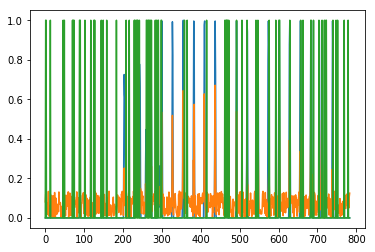

In [92]:
plt.plot(x_test)
plt.plot(x_noise)
print np.mean(x_test), np.mean(x_noise)
plt.plot(np.random.binomial(1,x_noise))

In [64]:
np.where(np.random.multinomial(1, np.ones(28)/28) == 1)[0][0]

23

In [119]:
lik_predictive

{0: {0: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16])},
  1: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16])},
  2: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16]),
   (0, 1): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16]),
   (1, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000